<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:09:22] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


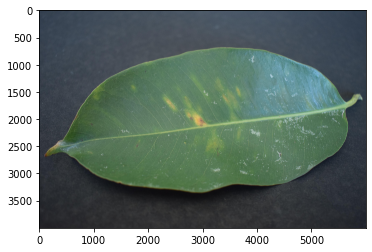

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

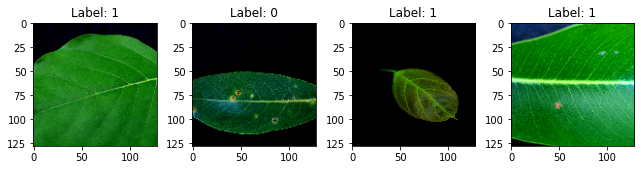

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:09:27] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:09:29] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.261062984914267 samples/sec                   batch loss = 0.6070202589035034 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2660572585266654 samples/sec                   batch loss = 0.9456303715705872 | accuracy = 0.425


Epoch[1] Batch[15] Speed: 1.2217219467430174 samples/sec                   batch loss = 0.5991336703300476 | accuracy = 0.4166666666666667


Epoch[1] Batch[20] Speed: 1.271138629910976 samples/sec                   batch loss = 0.4040100574493408 | accuracy = 0.4625


Epoch[1] Batch[25] Speed: 1.269090653827813 samples/sec                   batch loss = 0.8024367690086365 | accuracy = 0.48


Epoch[1] Batch[30] Speed: 1.2704622281456353 samples/sec                   batch loss = 0.34645509719848633 | accuracy = 0.5166666666666667


Epoch[1] Batch[35] Speed: 1.270459053344887 samples/sec                   batch loss = 0.5357876420021057 | accuracy = 0.5642857142857143


Epoch[1] Batch[40] Speed: 1.2683291692524439 samples/sec                   batch loss = 0.4924367368221283 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.268263971796023 samples/sec                   batch loss = 1.5563544034957886 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.268557125392955 samples/sec                   batch loss = 0.42786699533462524 | accuracy = 0.575


Epoch[1] Batch[55] Speed: 1.2689949503319335 samples/sec                   batch loss = 0.7194647789001465 | accuracy = 0.5954545454545455


Epoch[1] Batch[60] Speed: 1.2703314010188567 samples/sec                   batch loss = 0.5516084432601929 | accuracy = 0.5916666666666667


Epoch[1] Batch[65] Speed: 1.2635629425416517 samples/sec                   batch loss = 0.6412771344184875 | accuracy = 0.5961538461538461


Epoch[1] Batch[70] Speed: 1.2711578919613804 samples/sec                   batch loss = 1.0648123025894165 | accuracy = 0.6035714285714285


Epoch[1] Batch[75] Speed: 1.263586067879539 samples/sec                   batch loss = 0.9558779001235962 | accuracy = 0.6133333333333333


Epoch[1] Batch[80] Speed: 1.2715518325966002 samples/sec                   batch loss = 1.1054257154464722 | accuracy = 0.6125


Epoch[1] Batch[85] Speed: 1.2589822238681256 samples/sec                   batch loss = 0.5191035270690918 | accuracy = 0.6147058823529412


Epoch[1] Batch[90] Speed: 1.2649821968319228 samples/sec                   batch loss = 0.5958235263824463 | accuracy = 0.6166666666666667


Epoch[1] Batch[95] Speed: 1.2625627021338592 samples/sec                   batch loss = 0.32426944375038147 | accuracy = 0.6263157894736842


Epoch[1] Batch[100] Speed: 1.2714759928158021 samples/sec                   batch loss = 0.8857036828994751 | accuracy = 0.6225


Epoch[1] Batch[105] Speed: 1.2676648526782655 samples/sec                   batch loss = 0.6350778937339783 | accuracy = 0.6261904761904762


Epoch[1] Batch[110] Speed: 1.2621767796617693 samples/sec                   batch loss = 1.063973307609558 | accuracy = 0.6295454545454545


Epoch[1] Batch[115] Speed: 1.2643274786814689 samples/sec                   batch loss = 0.26461881399154663 | accuracy = 0.6369565217391304


Epoch[1] Batch[120] Speed: 1.2670907971361414 samples/sec                   batch loss = 0.25546103715896606 | accuracy = 0.64375


Epoch[1] Batch[125] Speed: 1.272568206335286 samples/sec                   batch loss = 0.5004964470863342 | accuracy = 0.644


Epoch[1] Batch[130] Speed: 1.2670976873140436 samples/sec                   batch loss = 0.3893947899341583 | accuracy = 0.65


Epoch[1] Batch[135] Speed: 1.2709300592944077 samples/sec                   batch loss = 0.3325255513191223 | accuracy = 0.6481481481481481


Epoch[1] Batch[140] Speed: 1.2655628393231118 samples/sec                   batch loss = 1.2052698135375977 | accuracy = 0.6464285714285715


Epoch[1] Batch[145] Speed: 1.2718057255915673 samples/sec                   batch loss = 0.4774005115032196 | accuracy = 0.6482758620689655


Epoch[1] Batch[150] Speed: 1.2730744910859755 samples/sec                   batch loss = 0.55121248960495 | accuracy = 0.65


Epoch[1] Batch[155] Speed: 1.2625328685518302 samples/sec                   batch loss = 0.7475925087928772 | accuracy = 0.6483870967741936


Epoch[1] Batch[160] Speed: 1.2685262405455295 samples/sec                   batch loss = 0.8989146947860718 | accuracy = 0.6515625


Epoch[1] Batch[165] Speed: 1.273718574908181 samples/sec                   batch loss = 0.5594720244407654 | accuracy = 0.6530303030303031


Epoch[1] Batch[170] Speed: 1.2702813860024773 samples/sec                   batch loss = 0.593958854675293 | accuracy = 0.6529411764705882


Epoch[1] Batch[175] Speed: 1.2682556308403867 samples/sec                   batch loss = 0.5475611686706543 | accuracy = 0.6571428571428571


Epoch[1] Batch[180] Speed: 1.2610828907222642 samples/sec                   batch loss = 0.4748220145702362 | accuracy = 0.6569444444444444


Epoch[1] Batch[185] Speed: 1.2697445497879978 samples/sec                   batch loss = 0.4227137863636017 | accuracy = 0.6581081081081082


Epoch[1] Batch[190] Speed: 1.272122511016339 samples/sec                   batch loss = 0.6729804277420044 | accuracy = 0.6618421052631579


Epoch[1] Batch[195] Speed: 1.2653297549280065 samples/sec                   batch loss = 0.7443513870239258 | accuracy = 0.6602564102564102


Epoch[1] Batch[200] Speed: 1.2613767166554468 samples/sec                   batch loss = 0.3572274446487427 | accuracy = 0.66375


Epoch[1] Batch[205] Speed: 1.2654984986871858 samples/sec                   batch loss = 0.7096925973892212 | accuracy = 0.6658536585365854


Epoch[1] Batch[210] Speed: 1.2721467224199001 samples/sec                   batch loss = 0.2990107238292694 | accuracy = 0.6678571428571428


Epoch[1] Batch[215] Speed: 1.2742959428965999 samples/sec                   batch loss = 1.598244309425354 | accuracy = 0.663953488372093


Epoch[1] Batch[220] Speed: 1.2750239125653557 samples/sec                   batch loss = 0.253054141998291 | accuracy = 0.6659090909090909


Epoch[1] Batch[225] Speed: 1.2660013698928874 samples/sec                   batch loss = 0.7594870924949646 | accuracy = 0.6644444444444444


Epoch[1] Batch[230] Speed: 1.2661222292942966 samples/sec                   batch loss = 0.48106056451797485 | accuracy = 0.6663043478260869


Epoch[1] Batch[235] Speed: 1.2632754215940136 samples/sec                   batch loss = 0.6459768414497375 | accuracy = 0.6723404255319149


Epoch[1] Batch[240] Speed: 1.268555207035646 samples/sec                   batch loss = 0.6858181357383728 | accuracy = 0.6697916666666667


Epoch[1] Batch[245] Speed: 1.2680112032792976 samples/sec                   batch loss = 0.4291589856147766 | accuracy = 0.6704081632653062


Epoch[1] Batch[250] Speed: 1.2616399393500182 samples/sec                   batch loss = 0.5027806758880615 | accuracy = 0.67


Epoch[1] Batch[255] Speed: 1.2673983442825107 samples/sec                   batch loss = 0.8725185990333557 | accuracy = 0.6686274509803921


Epoch[1] Batch[260] Speed: 1.2658514025629521 samples/sec                   batch loss = 0.3336176574230194 | accuracy = 0.6711538461538461


Epoch[1] Batch[265] Speed: 1.264354729192525 samples/sec                   batch loss = 0.6172829866409302 | accuracy = 0.6707547169811321


Epoch[1] Batch[270] Speed: 1.2683026100677 samples/sec                   batch loss = 0.44826099276542664 | accuracy = 0.6722222222222223


Epoch[1] Batch[275] Speed: 1.2619307977102159 samples/sec                   batch loss = 0.7343433499336243 | accuracy = 0.6745454545454546


Epoch[1] Batch[280] Speed: 1.2723499030184116 samples/sec                   batch loss = 0.18653921782970428 | accuracy = 0.6776785714285715


Epoch[1] Batch[285] Speed: 1.2673090224940868 samples/sec                   batch loss = 0.25526610016822815 | accuracy = 0.6798245614035088


Epoch[1] Batch[290] Speed: 1.2727335760728258 samples/sec                   batch loss = 0.496817409992218 | accuracy = 0.6818965517241379


Epoch[1] Batch[295] Speed: 1.2697327298856815 samples/sec                   batch loss = 0.4292377233505249 | accuracy = 0.6813559322033899


Epoch[1] Batch[300] Speed: 1.2680194451834474 samples/sec                   batch loss = 0.3562881052494049 | accuracy = 0.6833333333333333


Epoch[1] Batch[305] Speed: 1.2714297417364382 samples/sec                   batch loss = 0.2658228874206543 | accuracy = 0.6868852459016394


Epoch[1] Batch[310] Speed: 1.271830407006265 samples/sec                   batch loss = 0.3226918578147888 | accuracy = 0.6895161290322581


Epoch[1] Batch[315] Speed: 1.2743597292622406 samples/sec                   batch loss = 1.3147469758987427 | accuracy = 0.6873015873015873


Epoch[1] Batch[320] Speed: 1.2626859468709357 samples/sec                   batch loss = 0.6658060550689697 | accuracy = 0.68671875


Epoch[1] Batch[325] Speed: 1.2651904416269972 samples/sec                   batch loss = 0.6472619771957397 | accuracy = 0.6892307692307692


Epoch[1] Batch[330] Speed: 1.263058392868664 samples/sec                   batch loss = 0.3785431981086731 | accuracy = 0.6886363636363636


Epoch[1] Batch[335] Speed: 1.2640463715284096 samples/sec                   batch loss = 1.2542568445205688 | accuracy = 0.6895522388059702


Epoch[1] Batch[340] Speed: 1.2706612139842581 samples/sec                   batch loss = 0.507768988609314 | accuracy = 0.6897058823529412


Epoch[1] Batch[345] Speed: 1.2582816999731652 samples/sec                   batch loss = 0.8061277866363525 | accuracy = 0.6898550724637681


Epoch[1] Batch[350] Speed: 1.264010849092142 samples/sec                   batch loss = 0.484142005443573 | accuracy = 0.6907142857142857


Epoch[1] Batch[355] Speed: 1.2704808924466238 samples/sec                   batch loss = 0.46676912903785706 | accuracy = 0.6915492957746479


Epoch[1] Batch[360] Speed: 1.2679260112688808 samples/sec                   batch loss = 0.6534608602523804 | accuracy = 0.6895833333333333


Epoch[1] Batch[365] Speed: 1.2625983332592055 samples/sec                   batch loss = 0.41209399700164795 | accuracy = 0.689041095890411


Epoch[1] Batch[370] Speed: 1.2673072036388477 samples/sec                   batch loss = 0.2837137281894684 | accuracy = 0.6912162162162162


Epoch[1] Batch[375] Speed: 1.2738682843074614 samples/sec                   batch loss = 0.8944687247276306 | accuracy = 0.692


Epoch[1] Batch[380] Speed: 1.2719312636785625 samples/sec                   batch loss = 0.44623658061027527 | accuracy = 0.6914473684210526


Epoch[1] Batch[385] Speed: 1.2742782309718614 samples/sec                   batch loss = 0.5584056377410889 | accuracy = 0.6915584415584416


Epoch[1] Batch[390] Speed: 1.2634531325319442 samples/sec                   batch loss = 0.6130043268203735 | accuracy = 0.691025641025641


Epoch[1] Batch[395] Speed: 1.2712735728533355 samples/sec                   batch loss = 0.2683482766151428 | accuracy = 0.6943037974683545


Epoch[1] Batch[400] Speed: 1.2698370024694026 samples/sec                   batch loss = 0.4239942133426666 | accuracy = 0.696875


Epoch[1] Batch[405] Speed: 1.2638332668543146 samples/sec                   batch loss = 1.0603581666946411 | accuracy = 0.6981481481481482


Epoch[1] Batch[410] Speed: 1.2650800623928218 samples/sec                   batch loss = 0.5794010162353516 | accuracy = 0.697560975609756


Epoch[1] Batch[415] Speed: 1.264313949143839 samples/sec                   batch loss = 0.9695935845375061 | accuracy = 0.6981927710843373


Epoch[1] Batch[420] Speed: 1.274729603069341 samples/sec                   batch loss = 0.4619903862476349 | accuracy = 0.6970238095238095


Epoch[1] Batch[425] Speed: 1.267748860045713 samples/sec                   batch loss = 0.1949792504310608 | accuracy = 0.6970588235294117


Epoch[1] Batch[430] Speed: 1.267654987093161 samples/sec                   batch loss = 0.6274975538253784 | accuracy = 0.6976744186046512


Epoch[1] Batch[435] Speed: 1.2644298170975359 samples/sec                   batch loss = 0.5759392976760864 | accuracy = 0.6971264367816092


Epoch[1] Batch[440] Speed: 1.2703472719914257 samples/sec                   batch loss = 0.22300037741661072 | accuracy = 0.6971590909090909


Epoch[1] Batch[445] Speed: 1.2696092586975856 samples/sec                   batch loss = 0.4334687292575836 | accuracy = 0.6966292134831461


Epoch[1] Batch[450] Speed: 1.268035545956457 samples/sec                   batch loss = 0.4158973693847656 | accuracy = 0.6966666666666667


Epoch[1] Batch[455] Speed: 1.2651845262617238 samples/sec                   batch loss = 0.7454959154129028 | accuracy = 0.6956043956043956


Epoch[1] Batch[460] Speed: 1.2605223560833263 samples/sec                   batch loss = 0.3035110533237457 | accuracy = 0.6967391304347826


Epoch[1] Batch[465] Speed: 1.2658216998747247 samples/sec                   batch loss = 0.49574026465415955 | accuracy = 0.6967741935483871


Epoch[1] Batch[470] Speed: 1.2733455183930293 samples/sec                   batch loss = 0.5145831108093262 | accuracy = 0.6978723404255319


Epoch[1] Batch[475] Speed: 1.2616018008255914 samples/sec                   batch loss = 0.5468531250953674 | accuracy = 0.6973684210526315


Epoch[1] Batch[480] Speed: 1.2624413813581112 samples/sec                   batch loss = 0.4850894510746002 | accuracy = 0.6963541666666667


Epoch[1] Batch[485] Speed: 1.2614799058319668 samples/sec                   batch loss = 0.4194125831127167 | accuracy = 0.6979381443298969


Epoch[1] Batch[490] Speed: 1.2661338865198815 samples/sec                   batch loss = 0.8002125024795532 | accuracy = 0.698469387755102


Epoch[1] Batch[495] Speed: 1.2693510557487389 samples/sec                   batch loss = 0.45914313197135925 | accuracy = 0.7


Epoch[1] Batch[500] Speed: 1.2742284853577637 samples/sec                   batch loss = 0.9653904438018799 | accuracy = 0.699


Epoch[1] Batch[505] Speed: 1.2627572250467536 samples/sec                   batch loss = 0.141945481300354 | accuracy = 0.699009900990099


Epoch[1] Batch[510] Speed: 1.2671405612158773 samples/sec                   batch loss = 0.8341561555862427 | accuracy = 0.7


Epoch[1] Batch[515] Speed: 1.273858515372967 samples/sec                   batch loss = 0.32101520895957947 | accuracy = 0.7


Epoch[1] Batch[520] Speed: 1.2661449706383727 samples/sec                   batch loss = 0.830333948135376 | accuracy = 0.6995192307692307


Epoch[1] Batch[525] Speed: 1.2665560800363753 samples/sec                   batch loss = 0.40453237295150757 | accuracy = 0.7


Epoch[1] Batch[530] Speed: 1.2596240396869938 samples/sec                   batch loss = 0.661707878112793 | accuracy = 0.6981132075471698


Epoch[1] Batch[535] Speed: 1.2667509747031342 samples/sec                   batch loss = 0.5436856746673584 | accuracy = 0.7004672897196261


Epoch[1] Batch[540] Speed: 1.2714810999121031 samples/sec                   batch loss = 2.3320581912994385 | accuracy = 0.700462962962963


Epoch[1] Batch[545] Speed: 1.2671360631479855 samples/sec                   batch loss = 0.7454540729522705 | accuracy = 0.7004587155963303


Epoch[1] Batch[550] Speed: 1.2679258196237202 samples/sec                   batch loss = 0.4193955957889557 | accuracy = 0.7013636363636364


Epoch[1] Batch[555] Speed: 1.2643141396986965 samples/sec                   batch loss = 0.39151138067245483 | accuracy = 0.7022522522522523


Epoch[1] Batch[560] Speed: 1.2699901267998077 samples/sec                   batch loss = 0.6791121959686279 | accuracy = 0.7026785714285714


Epoch[1] Batch[565] Speed: 1.2669377014042158 samples/sec                   batch loss = 0.4077141284942627 | accuracy = 0.702212389380531


Epoch[1] Batch[570] Speed: 1.2682394286079293 samples/sec                   batch loss = 0.6352034211158752 | accuracy = 0.7013157894736842


Epoch[1] Batch[575] Speed: 1.2613395423389477 samples/sec                   batch loss = 0.2121357023715973 | accuracy = 0.7021739130434783


Epoch[1] Batch[580] Speed: 1.2656373069799711 samples/sec                   batch loss = 0.27441394329071045 | accuracy = 0.7043103448275863


Epoch[1] Batch[585] Speed: 1.2649790493605404 samples/sec                   batch loss = 0.4363453984260559 | accuracy = 0.7047008547008548


Epoch[1] Batch[590] Speed: 1.2697411863787595 samples/sec                   batch loss = 0.7639990448951721 | accuracy = 0.7038135593220339


Epoch[1] Batch[595] Speed: 1.270848710275979 samples/sec                   batch loss = 0.4258735775947571 | accuracy = 0.7037815126050421


Epoch[1] Batch[600] Speed: 1.262059425481116 samples/sec                   batch loss = 0.6951626539230347 | accuracy = 0.7041666666666667


Epoch[1] Batch[605] Speed: 1.2688204749912027 samples/sec                   batch loss = 0.527845025062561 | accuracy = 0.7041322314049587


Epoch[1] Batch[610] Speed: 1.2688741176911915 samples/sec                   batch loss = 0.7131717205047607 | accuracy = 0.7040983606557377


Epoch[1] Batch[615] Speed: 1.2679390432757132 samples/sec                   batch loss = 0.5108006596565247 | accuracy = 0.7044715447154472


Epoch[1] Batch[620] Speed: 1.265845098982048 samples/sec                   batch loss = 0.3431958556175232 | accuracy = 0.7052419354838709


Epoch[1] Batch[625] Speed: 1.2603148876150434 samples/sec                   batch loss = 0.25003448128700256 | accuracy = 0.706


Epoch[1] Batch[630] Speed: 1.2689592452024738 samples/sec                   batch loss = 1.5499241352081299 | accuracy = 0.7063492063492064


Epoch[1] Batch[635] Speed: 1.2703130296609768 samples/sec                   batch loss = 0.6211866140365601 | accuracy = 0.7062992125984252


Epoch[1] Batch[640] Speed: 1.2728844060276754 samples/sec                   batch loss = 0.49362435936927795 | accuracy = 0.707421875


Epoch[1] Batch[645] Speed: 1.2649826737228924 samples/sec                   batch loss = 0.8104823231697083 | accuracy = 0.7065891472868217


Epoch[1] Batch[650] Speed: 1.2682341557813257 samples/sec                   batch loss = 0.4691619873046875 | accuracy = 0.7073076923076923


Epoch[1] Batch[655] Speed: 1.2734520284341166 samples/sec                   batch loss = 0.3603554368019104 | accuracy = 0.7083969465648855


Epoch[1] Batch[660] Speed: 1.269113885940832 samples/sec                   batch loss = 0.6716728210449219 | accuracy = 0.7075757575757575


Epoch[1] Batch[665] Speed: 1.2691394230463735 samples/sec                   batch loss = 0.45133352279663086 | accuracy = 0.7086466165413534


Epoch[1] Batch[670] Speed: 1.2605374146460284 samples/sec                   batch loss = 0.4854312539100647 | accuracy = 0.7089552238805971


Epoch[1] Batch[675] Speed: 1.26895694171473 samples/sec                   batch loss = 0.2882031202316284 | accuracy = 0.7092592592592593


Epoch[1] Batch[680] Speed: 1.2714172159815018 samples/sec                   batch loss = 0.9537204504013062 | accuracy = 0.7095588235294118


Epoch[1] Batch[685] Speed: 1.2692680842461779 samples/sec                   batch loss = 0.5838444232940674 | accuracy = 0.7105839416058394


Epoch[1] Batch[690] Speed: 1.266851409991166 samples/sec                   batch loss = 0.4421786665916443 | accuracy = 0.7097826086956521


Epoch[1] Batch[695] Speed: 1.258577904046542 samples/sec                   batch loss = 0.554529070854187 | accuracy = 0.710431654676259


Epoch[1] Batch[700] Speed: 1.2676108332977594 samples/sec                   batch loss = 0.7804729342460632 | accuracy = 0.7107142857142857


Epoch[1] Batch[705] Speed: 1.2660817173271433 samples/sec                   batch loss = 0.4742874801158905 | accuracy = 0.7113475177304964


Epoch[1] Batch[710] Speed: 1.2660170373198183 samples/sec                   batch loss = 0.930819571018219 | accuracy = 0.7105633802816902


Epoch[1] Batch[715] Speed: 1.2660009877653675 samples/sec                   batch loss = 0.40144410729408264 | accuracy = 0.7111888111888112


Epoch[1] Batch[720] Speed: 1.2680417755319082 samples/sec                   batch loss = 0.25325095653533936 | accuracy = 0.7121527777777777


Epoch[1] Batch[725] Speed: 1.2681391565444986 samples/sec                   batch loss = 1.6778165102005005 | accuracy = 0.7120689655172414


Epoch[1] Batch[730] Speed: 1.267642152484122 samples/sec                   batch loss = 0.8383891582489014 | accuracy = 0.711986301369863


Epoch[1] Batch[735] Speed: 1.2691942448905886 samples/sec                   batch loss = 0.6126260757446289 | accuracy = 0.7125850340136054


Epoch[1] Batch[740] Speed: 1.2650771052193241 samples/sec                   batch loss = 0.497702419757843 | accuracy = 0.7118243243243243


Epoch[1] Batch[745] Speed: 1.2667900947456485 samples/sec                   batch loss = 0.7750738263130188 | accuracy = 0.7124161073825503


Epoch[1] Batch[750] Speed: 1.2655055624729066 samples/sec                   batch loss = 1.7610290050506592 | accuracy = 0.7123333333333334


Epoch[1] Batch[755] Speed: 1.2679225616648546 samples/sec                   batch loss = 0.2894980013370514 | accuracy = 0.7142384105960264


Epoch[1] Batch[760] Speed: 1.2637479689488234 samples/sec                   batch loss = 0.9278571009635925 | accuracy = 0.7144736842105263


Epoch[1] Batch[765] Speed: 1.2553946592874925 samples/sec                   batch loss = 0.6139906644821167 | accuracy = 0.7156862745098039


Epoch[1] Batch[770] Speed: 1.2666080970826714 samples/sec                   batch loss = 0.5312497019767761 | accuracy = 0.714935064935065


Epoch[1] Batch[775] Speed: 1.266682305264165 samples/sec                   batch loss = 0.4157848656177521 | accuracy = 0.7151612903225807


Epoch[1] Batch[780] Speed: 1.2717130824216678 samples/sec                   batch loss = 0.4954090714454651 | accuracy = 0.7153846153846154


Epoch[1] Batch[785] Speed: 1.265765736539124 samples/sec                   batch loss = 0.5135418772697449 | accuracy = 0.7156050955414013


[Epoch 1] training: accuracy=0.7157360406091371
[Epoch 1] time cost: 647.8622453212738
[Epoch 1] validation: validation accuracy=0.75


Epoch[2] Batch[5] Speed: 1.2655761091997757 samples/sec                   batch loss = 0.7985846996307373 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2735398981317834 samples/sec                   batch loss = 1.1312379837036133 | accuracy = 0.55


Epoch[2] Batch[15] Speed: 1.2830351094515728 samples/sec                   batch loss = 1.9353857040405273 | accuracy = 0.6


Epoch[2] Batch[20] Speed: 1.255765823534726 samples/sec                   batch loss = 0.5060093998908997 | accuracy = 0.6625


Epoch[2] Batch[25] Speed: 1.2622536033991103 samples/sec                   batch loss = 0.261468768119812 | accuracy = 0.67


Epoch[2] Batch[30] Speed: 1.277224002275328 samples/sec                   batch loss = 0.29846829175949097 | accuracy = 0.6916666666666667


Epoch[2] Batch[35] Speed: 1.2765438300402345 samples/sec                   batch loss = 0.73725825548172 | accuracy = 0.7071428571428572


Epoch[2] Batch[40] Speed: 1.2705887520604107 samples/sec                   batch loss = 0.31250253319740295 | accuracy = 0.7125


Epoch[2] Batch[45] Speed: 1.2635500954974603 samples/sec                   batch loss = 0.4169761836528778 | accuracy = 0.7222222222222222


Epoch[2] Batch[50] Speed: 1.270997264326679 samples/sec                   batch loss = 0.7859204411506653 | accuracy = 0.725


Epoch[2] Batch[55] Speed: 1.2814193455550207 samples/sec                   batch loss = 0.4022894501686096 | accuracy = 0.7227272727272728


Epoch[2] Batch[60] Speed: 1.2770183873209242 samples/sec                   batch loss = 0.39970895648002625 | accuracy = 0.7208333333333333


Epoch[2] Batch[65] Speed: 1.2679738285469329 samples/sec                   batch loss = 0.47226306796073914 | accuracy = 0.7230769230769231


Epoch[2] Batch[70] Speed: 1.2701891570987305 samples/sec                   batch loss = 0.6831643581390381 | accuracy = 0.7178571428571429


Epoch[2] Batch[75] Speed: 1.272699204977186 samples/sec                   batch loss = 0.4625605642795563 | accuracy = 0.72


Epoch[2] Batch[80] Speed: 1.273420034888998 samples/sec                   batch loss = 0.45779478549957275 | accuracy = 0.728125


Epoch[2] Batch[85] Speed: 1.2748508754466137 samples/sec                   batch loss = 1.3079890012741089 | accuracy = 0.7264705882352941


Epoch[2] Batch[90] Speed: 1.2706955713303807 samples/sec                   batch loss = 0.713057279586792 | accuracy = 0.7166666666666667


Epoch[2] Batch[95] Speed: 1.2636535454112914 samples/sec                   batch loss = 0.5002225041389465 | accuracy = 0.7236842105263158


Epoch[2] Batch[100] Speed: 1.2690685745087291 samples/sec                   batch loss = 0.8342182040214539 | accuracy = 0.7225


Epoch[2] Batch[105] Speed: 1.2716782844684276 samples/sec                   batch loss = 0.5617548227310181 | accuracy = 0.719047619047619


Epoch[2] Batch[110] Speed: 1.2699858007468876 samples/sec                   batch loss = 0.31505486369132996 | accuracy = 0.7113636363636363


Epoch[2] Batch[115] Speed: 1.2651549502650516 samples/sec                   batch loss = 0.41642647981643677 | accuracy = 0.7152173913043478


Epoch[2] Batch[120] Speed: 1.2688734459298745 samples/sec                   batch loss = 0.3725140690803528 | accuracy = 0.7145833333333333


Epoch[2] Batch[125] Speed: 1.2702324328101726 samples/sec                   batch loss = 0.5438469648361206 | accuracy = 0.716


Epoch[2] Batch[130] Speed: 1.2680608479973106 samples/sec                   batch loss = 0.3725387454032898 | accuracy = 0.7230769230769231


Epoch[2] Batch[135] Speed: 1.2691194540942778 samples/sec                   batch loss = 0.7427504062652588 | accuracy = 0.725925925925926


Epoch[2] Batch[140] Speed: 1.260937592772832 samples/sec                   batch loss = 0.8723899722099304 | accuracy = 0.7267857142857143


Epoch[2] Batch[145] Speed: 1.2646024196808408 samples/sec                   batch loss = 0.5417443513870239 | accuracy = 0.7189655172413794


Epoch[2] Batch[150] Speed: 1.267287962384761 samples/sec                   batch loss = 0.4007561206817627 | accuracy = 0.7216666666666667


Epoch[2] Batch[155] Speed: 1.2696117567092862 samples/sec                   batch loss = 0.25302472710609436 | accuracy = 0.7209677419354839


Epoch[2] Batch[160] Speed: 1.2663597159532172 samples/sec                   batch loss = 0.5548204779624939 | accuracy = 0.7203125


Epoch[2] Batch[165] Speed: 1.2666011166058275 samples/sec                   batch loss = 0.4315733313560486 | accuracy = 0.7227272727272728


Epoch[2] Batch[170] Speed: 1.2651943534311914 samples/sec                   batch loss = 0.44012200832366943 | accuracy = 0.7279411764705882


Epoch[2] Batch[175] Speed: 1.2734456489282229 samples/sec                   batch loss = 0.5538815855979919 | accuracy = 0.7328571428571429


Epoch[2] Batch[180] Speed: 1.2788720885205613 samples/sec                   batch loss = 0.3851361572742462 | accuracy = 0.7333333333333333


Epoch[2] Batch[185] Speed: 1.2687667408768815 samples/sec                   batch loss = 0.6619421243667603 | accuracy = 0.7297297297297297


Epoch[2] Batch[190] Speed: 1.2719283708169697 samples/sec                   batch loss = 0.45127663016319275 | accuracy = 0.7302631578947368


Epoch[2] Batch[195] Speed: 1.2689992696370513 samples/sec                   batch loss = 0.34447118639945984 | accuracy = 0.732051282051282


Epoch[2] Batch[200] Speed: 1.2637479689488234 samples/sec                   batch loss = 0.23265765607357025 | accuracy = 0.73375


Epoch[2] Batch[205] Speed: 1.2636142381589566 samples/sec                   batch loss = 0.34121301770210266 | accuracy = 0.7378048780487805


Epoch[2] Batch[210] Speed: 1.2620111988606013 samples/sec                   batch loss = 0.6707025170326233 | accuracy = 0.7380952380952381


Epoch[2] Batch[215] Speed: 1.2695177037439205 samples/sec                   batch loss = 0.3132236897945404 | accuracy = 0.7383720930232558


Epoch[2] Batch[220] Speed: 1.266451485160772 samples/sec                   batch loss = 0.5397117733955383 | accuracy = 0.7352272727272727


Epoch[2] Batch[225] Speed: 1.2663334303494633 samples/sec                   batch loss = 0.35549917817115784 | accuracy = 0.7344444444444445


Epoch[2] Batch[230] Speed: 1.267530674723798 samples/sec                   batch loss = 0.6558944582939148 | accuracy = 0.7347826086956522


Epoch[2] Batch[235] Speed: 1.264640453862663 samples/sec                   batch loss = 0.19172339141368866 | accuracy = 0.7372340425531915


Epoch[2] Batch[240] Speed: 1.2730983523161183 samples/sec                   batch loss = 0.3314046561717987 | accuracy = 0.7385416666666667


Epoch[2] Batch[245] Speed: 1.2744390113543405 samples/sec                   batch loss = 0.6876906752586365 | accuracy = 0.7346938775510204


Epoch[2] Batch[250] Speed: 1.2737555154300697 samples/sec                   batch loss = 0.5544931292533875 | accuracy = 0.736


Epoch[2] Batch[255] Speed: 1.2724810497420143 samples/sec                   batch loss = 0.4590472877025604 | accuracy = 0.7362745098039216


Epoch[2] Batch[260] Speed: 1.2649825783446698 samples/sec                   batch loss = 0.4413827657699585 | accuracy = 0.7365384615384616


Epoch[2] Batch[265] Speed: 1.2703861335015751 samples/sec                   batch loss = 1.6094508171081543 | accuracy = 0.7367924528301887


Epoch[2] Batch[270] Speed: 1.2706763232885532 samples/sec                   batch loss = 0.5508579015731812 | accuracy = 0.7398148148148148


Epoch[2] Batch[275] Speed: 1.2693670943156283 samples/sec                   batch loss = 0.3069896399974823 | accuracy = 0.7436363636363637


Epoch[2] Batch[280] Speed: 1.258259617683596 samples/sec                   batch loss = 0.6821393370628357 | accuracy = 0.74375


Epoch[2] Batch[285] Speed: 1.2682788323911387 samples/sec                   batch loss = 0.3777439296245575 | accuracy = 0.743859649122807


Epoch[2] Batch[290] Speed: 1.2752817145184434 samples/sec                   batch loss = 0.6446152925491333 | accuracy = 0.7422413793103448


Epoch[2] Batch[295] Speed: 1.2665411641716522 samples/sec                   batch loss = 0.0967063382267952 | accuracy = 0.7406779661016949


Epoch[2] Batch[300] Speed: 1.2648414343359957 samples/sec                   batch loss = 0.5797868967056274 | accuracy = 0.74


Epoch[2] Batch[305] Speed: 1.2581539354056472 samples/sec                   batch loss = 0.9200224280357361 | accuracy = 0.7377049180327869


Epoch[2] Batch[310] Speed: 1.2650665167437243 samples/sec                   batch loss = 0.33325648307800293 | accuracy = 0.7411290322580645


Epoch[2] Batch[315] Speed: 1.2690631027962673 samples/sec                   batch loss = 0.46565407514572144 | accuracy = 0.7388888888888889


Epoch[2] Batch[320] Speed: 1.272818932552845 samples/sec                   batch loss = 0.24016207456588745 | accuracy = 0.73984375


Epoch[2] Batch[325] Speed: 1.2644206688553767 samples/sec                   batch loss = 0.5126581788063049 | accuracy = 0.7407692307692307


Epoch[2] Batch[330] Speed: 1.2630193127974574 samples/sec                   batch loss = 0.2982735335826874 | accuracy = 0.740909090909091


Epoch[2] Batch[335] Speed: 1.2610523687402846 samples/sec                   batch loss = 0.3866826593875885 | accuracy = 0.7417910447761195


Epoch[2] Batch[340] Speed: 1.2626613340100756 samples/sec                   batch loss = 0.6085973381996155 | accuracy = 0.7397058823529412


Epoch[2] Batch[345] Speed: 1.2643553008941486 samples/sec                   batch loss = 0.4248109757900238 | accuracy = 0.7405797101449275


Epoch[2] Batch[350] Speed: 1.253408671859638 samples/sec                   batch loss = 0.2788597643375397 | accuracy = 0.7428571428571429


Epoch[2] Batch[355] Speed: 1.2634203074220414 samples/sec                   batch loss = 0.53559809923172 | accuracy = 0.7443661971830986


Epoch[2] Batch[360] Speed: 1.269841711958013 samples/sec                   batch loss = 0.3085472285747528 | accuracy = 0.7416666666666667


Epoch[2] Batch[365] Speed: 1.2703768988679578 samples/sec                   batch loss = 0.35446956753730774 | accuracy = 0.7376712328767123


Epoch[2] Batch[370] Speed: 1.2611846097316464 samples/sec                   batch loss = 0.49256908893585205 | accuracy = 0.7385135135135135


Epoch[2] Batch[375] Speed: 1.2613388785317805 samples/sec                   batch loss = 0.5704681277275085 | accuracy = 0.7393333333333333


Epoch[2] Batch[380] Speed: 1.2698754482957608 samples/sec                   batch loss = 0.6939067840576172 | accuracy = 0.7388157894736842


Epoch[2] Batch[385] Speed: 1.270586635103228 samples/sec                   batch loss = 0.6507070064544678 | accuracy = 0.7383116883116884


Epoch[2] Batch[390] Speed: 1.27261685706748 samples/sec                   batch loss = 0.4110502004623413 | accuracy = 0.7403846153846154


Epoch[2] Batch[395] Speed: 1.2589809012122066 samples/sec                   batch loss = 0.3643009662628174 | accuracy = 0.7417721518987341


Epoch[2] Batch[400] Speed: 1.2636314645230073 samples/sec                   batch loss = 0.5912131071090698 | accuracy = 0.740625


Epoch[2] Batch[405] Speed: 1.2668261561914549 samples/sec                   batch loss = 0.45631998777389526 | accuracy = 0.7419753086419754


Epoch[2] Batch[410] Speed: 1.2667652259791877 samples/sec                   batch loss = 1.1123201847076416 | accuracy = 0.7408536585365854


Epoch[2] Batch[415] Speed: 1.2673365931497023 samples/sec                   batch loss = 0.2835867404937744 | accuracy = 0.7433734939759036


Epoch[2] Batch[420] Speed: 1.256117551383209 samples/sec                   batch loss = 0.5043337345123291 | accuracy = 0.743452380952381


Epoch[2] Batch[425] Speed: 1.2684497063180185 samples/sec                   batch loss = 0.5872544646263123 | accuracy = 0.7447058823529412


Epoch[2] Batch[430] Speed: 1.268108579596088 samples/sec                   batch loss = 0.551710307598114 | accuracy = 0.7447674418604651


Epoch[2] Batch[435] Speed: 1.2695900435515917 samples/sec                   batch loss = 0.5834153890609741 | accuracy = 0.7442528735632183


Epoch[2] Batch[440] Speed: 1.268146441552218 samples/sec                   batch loss = 0.5246068835258484 | accuracy = 0.7448863636363636


Epoch[2] Batch[445] Speed: 1.2620480330335333 samples/sec                   batch loss = 0.6704162955284119 | accuracy = 0.7438202247191011


Epoch[2] Batch[450] Speed: 1.2611612878007126 samples/sec                   batch loss = 0.4053087830543518 | accuracy = 0.7433333333333333


Epoch[2] Batch[455] Speed: 1.267013096428522 samples/sec                   batch loss = 0.9270671606063843 | accuracy = 0.7412087912087912


Epoch[2] Batch[460] Speed: 1.2709395908077183 samples/sec                   batch loss = 0.46397656202316284 | accuracy = 0.7423913043478261


Epoch[2] Batch[465] Speed: 1.2617222960688723 samples/sec                   batch loss = 0.9586352705955505 | accuracy = 0.7424731182795699


Epoch[2] Batch[470] Speed: 1.259967996909487 samples/sec                   batch loss = 0.1691468507051468 | accuracy = 0.7420212765957447


Epoch[2] Batch[475] Speed: 1.2642697419693116 samples/sec                   batch loss = 0.330740362405777 | accuracy = 0.7431578947368421


Epoch[2] Batch[480] Speed: 1.2721004225317725 samples/sec                   batch loss = 0.4359983801841736 | accuracy = 0.7432291666666667


Epoch[2] Batch[485] Speed: 1.2681557396441832 samples/sec                   batch loss = 0.18696367740631104 | accuracy = 0.7448453608247423


Epoch[2] Batch[490] Speed: 1.2573795997901522 samples/sec                   batch loss = 0.378539115190506 | accuracy = 0.746938775510204


Epoch[2] Batch[495] Speed: 1.2585314536545027 samples/sec                   batch loss = 0.5014722943305969 | accuracy = 0.747979797979798


Epoch[2] Batch[500] Speed: 1.2677060407602632 samples/sec                   batch loss = 0.6617285013198853 | accuracy = 0.746


Epoch[2] Batch[505] Speed: 1.2697235047489712 samples/sec                   batch loss = 0.2650994062423706 | accuracy = 0.7475247524752475


Epoch[2] Batch[510] Speed: 1.26458535747047 samples/sec                   batch loss = 0.20473241806030273 | accuracy = 0.7490196078431373


Epoch[2] Batch[515] Speed: 1.2584581030059112 samples/sec                   batch loss = 0.9590765833854675 | accuracy = 0.7490291262135922


Epoch[2] Batch[520] Speed: 1.2681199858714944 samples/sec                   batch loss = 0.4377139210700989 | accuracy = 0.7485576923076923


Epoch[2] Batch[525] Speed: 1.2697337869411562 samples/sec                   batch loss = 0.17715665698051453 | accuracy = 0.7495238095238095


Epoch[2] Batch[530] Speed: 1.273693626762694 samples/sec                   batch loss = 0.4774610698223114 | accuracy = 0.7481132075471698


Epoch[2] Batch[535] Speed: 1.2596013428467285 samples/sec                   batch loss = 0.66935133934021 | accuracy = 0.7467289719626168


Epoch[2] Batch[540] Speed: 1.2596973371525966 samples/sec                   batch loss = 0.3228135406970978 | accuracy = 0.7481481481481481


Epoch[2] Batch[545] Speed: 1.265445522807746 samples/sec                   batch loss = 0.649071991443634 | accuracy = 0.7444954128440368


Epoch[2] Batch[550] Speed: 1.267965874721566 samples/sec                   batch loss = 0.4236341416835785 | accuracy = 0.745


Epoch[2] Batch[555] Speed: 1.267125057371847 samples/sec                   batch loss = 0.2371688038110733 | accuracy = 0.7450450450450451


Epoch[2] Batch[560] Speed: 1.260888693753567 samples/sec                   batch loss = 0.31617340445518494 | accuracy = 0.7455357142857143


Epoch[2] Batch[565] Speed: 1.2644451597591608 samples/sec                   batch loss = 0.4209102988243103 | accuracy = 0.7451327433628319


Epoch[2] Batch[570] Speed: 1.2685048522313322 samples/sec                   batch loss = 0.6051541566848755 | accuracy = 0.7456140350877193


Epoch[2] Batch[575] Speed: 1.2640138965150824 samples/sec                   batch loss = 0.7401549816131592 | accuracy = 0.7452173913043478


Epoch[2] Batch[580] Speed: 1.2654223293593132 samples/sec                   batch loss = 0.21364210546016693 | accuracy = 0.746551724137931


Epoch[2] Batch[585] Speed: 1.2612337213335572 samples/sec                   batch loss = 0.30011892318725586 | accuracy = 0.7465811965811966


Epoch[2] Batch[590] Speed: 1.2679171956514559 samples/sec                   batch loss = 0.9267564415931702 | accuracy = 0.7461864406779661


Epoch[2] Batch[595] Speed: 1.2679919406420836 samples/sec                   batch loss = 0.35979416966438293 | accuracy = 0.7449579831932773


Epoch[2] Batch[600] Speed: 1.2731388315092986 samples/sec                   batch loss = 0.08440439403057098 | accuracy = 0.7458333333333333


Epoch[2] Batch[605] Speed: 1.2621351904895346 samples/sec                   batch loss = 0.25427111983299255 | accuracy = 0.7475206611570248


Epoch[2] Batch[610] Speed: 1.2702795586053044 samples/sec                   batch loss = 0.2723788022994995 | accuracy = 0.7471311475409836


Epoch[2] Batch[615] Speed: 1.2697280212054034 samples/sec                   batch loss = 0.26577192544937134 | accuracy = 0.7483739837398374


Epoch[2] Batch[620] Speed: 1.2712962106282693 samples/sec                   batch loss = 0.44188573956489563 | accuracy = 0.7491935483870967


Epoch[2] Batch[625] Speed: 1.2718542216230324 samples/sec                   batch loss = 0.4747939109802246 | accuracy = 0.7476


Epoch[2] Batch[630] Speed: 1.263059438840539 samples/sec                   batch loss = 0.2772834300994873 | accuracy = 0.7476190476190476


Epoch[2] Batch[635] Speed: 1.2668362958536998 samples/sec                   batch loss = 0.20628535747528076 | accuracy = 0.7492125984251968


Epoch[2] Batch[640] Speed: 1.2680442673792274 samples/sec                   batch loss = 0.8387718200683594 | accuracy = 0.7484375


Epoch[2] Batch[645] Speed: 1.2704755047570468 samples/sec                   batch loss = 1.0313018560409546 | accuracy = 0.7484496124031008


Epoch[2] Batch[650] Speed: 1.2597678053388328 samples/sec                   batch loss = 0.26632606983184814 | accuracy = 0.7476923076923077


Epoch[2] Batch[655] Speed: 1.264299467142729 samples/sec                   batch loss = 0.2914949655532837 | accuracy = 0.7458015267175573


Epoch[2] Batch[660] Speed: 1.2696110841667074 samples/sec                   batch loss = 0.6450161933898926 | accuracy = 0.7454545454545455


Epoch[2] Batch[665] Speed: 1.2675931151774509 samples/sec                   batch loss = 0.3281468152999878 | accuracy = 0.7458646616541353


Epoch[2] Batch[670] Speed: 1.2665509168126752 samples/sec                   batch loss = 0.31784963607788086 | accuracy = 0.7466417910447761


Epoch[2] Batch[675] Speed: 1.2626993465537866 samples/sec                   batch loss = 0.49839213490486145 | accuracy = 0.7462962962962963


Epoch[2] Batch[680] Speed: 1.26174895993726 samples/sec                   batch loss = 0.8999758362770081 | accuracy = 0.7466911764705882


Epoch[2] Batch[685] Speed: 1.2662071790766127 samples/sec                   batch loss = 0.28175321221351624 | accuracy = 0.7467153284671533


Epoch[2] Batch[690] Speed: 1.2638961052658144 samples/sec                   batch loss = 0.285190612077713 | accuracy = 0.7467391304347826


Epoch[2] Batch[695] Speed: 1.2616537912257195 samples/sec                   batch loss = 0.42786338925361633 | accuracy = 0.7467625899280576


Epoch[2] Batch[700] Speed: 1.2525876984883955 samples/sec                   batch loss = 0.7346253395080566 | accuracy = 0.7464285714285714


Epoch[2] Batch[705] Speed: 1.265813773026374 samples/sec                   batch loss = 0.22905233502388 | accuracy = 0.747872340425532


Epoch[2] Batch[710] Speed: 1.261885333353591 samples/sec                   batch loss = 0.14368963241577148 | accuracy = 0.7492957746478873


Epoch[2] Batch[715] Speed: 1.2706507242964271 samples/sec                   batch loss = 1.085167646408081 | accuracy = 0.7493006993006993


Epoch[2] Batch[720] Speed: 1.2662421560904693 samples/sec                   batch loss = 0.7651952505111694 | accuracy = 0.7496527777777777


Epoch[2] Batch[725] Speed: 1.2614450965665631 samples/sec                   batch loss = 0.5072112679481506 | accuracy = 0.75


Epoch[2] Batch[730] Speed: 1.2587759231386026 samples/sec                   batch loss = 0.4077046513557434 | accuracy = 0.75


Epoch[2] Batch[735] Speed: 1.264074086129224 samples/sec                   batch loss = 0.2705264687538147 | accuracy = 0.7489795918367347


Epoch[2] Batch[740] Speed: 1.2645658175157861 samples/sec                   batch loss = 0.21479743719100952 | accuracy = 0.7496621621621622


Epoch[2] Batch[745] Speed: 1.2691641931005015 samples/sec                   batch loss = 0.5980038642883301 | accuracy = 0.7493288590604027


Epoch[2] Batch[750] Speed: 1.2579264013436104 samples/sec                   batch loss = 0.5441463589668274 | accuracy = 0.7486666666666667


Epoch[2] Batch[755] Speed: 1.2686082517530002 samples/sec                   batch loss = 0.29738032817840576 | accuracy = 0.7486754966887417


Epoch[2] Batch[760] Speed: 1.2683236080314384 samples/sec                   batch loss = 1.0582901239395142 | accuracy = 0.7480263157894737


Epoch[2] Batch[765] Speed: 1.2642961325184128 samples/sec                   batch loss = 0.19605115056037903 | accuracy = 0.7483660130718954


Epoch[2] Batch[770] Speed: 1.2579171583329698 samples/sec                   batch loss = 0.6341503262519836 | accuracy = 0.7483766233766234


Epoch[2] Batch[775] Speed: 1.2650057556756948 samples/sec                   batch loss = 0.38164541125297546 | accuracy = 0.7480645161290322


Epoch[2] Batch[780] Speed: 1.266094711449282 samples/sec                   batch loss = 0.2846487760543823 | accuracy = 0.7480769230769231


Epoch[2] Batch[785] Speed: 1.2672659457461255 samples/sec                   batch loss = 0.4892289936542511 | accuracy = 0.7487261146496815


[Epoch 2] training: accuracy=0.7490482233502538
[Epoch 2] time cost: 639.8295788764954
[Epoch 2] validation: validation accuracy=0.75


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7377777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)